# Download the inventory data for the following criterias
Select an earthquake event (by id).\
Get the station inventory within the study area which recorded this event.\
Use this station inventory data to download earthquake data (`.mseed`) and station data (`.txt` or `.xml` format).\
3-channel data for earthquakes are along x, y and z axis. Usually named as HHE, HHN and HHZ or HH1, HH2, HHZ.\
I want to select the following channels in order. If the 1st one is available, get that one only and stop. If not search for the 2nd one and so on.
1. HH*
2. BH*
3. HN*
4. EH* \
Lastly, 


In [1]:
import os
import time
import pandas as pd
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, read_inventory, Inventory, read, Stream

In [18]:

# Read earthquake data
eqdf = pd.read_csv("../data/above_slab_eq_df.csv", parse_dates=["time"])
eqdf4 = eqdf[eqdf.mag >= 4].reset_index(drop=True)

# Extract unique grid codes
unique_grid_codes = eqdf4['grid_code'].unique()

# Loop through each grid code
for i in range(len(unique_grid_codes)):
    temp_df = eqdf4[eqdf4.grid_code == unique_grid_codes[i]].reset_index(drop=True) # select events in the grid

    # Check if there are events in the grid
    if len(temp_df) > 0:
        print(temp_df[['id', 'mag', 'time']])
        # Select the event with maximum magnitude
        eq_idx = temp_df['mag'].idxmax()
        print(f"Selected event index: {eq_idx}")

        # get the details of the event
        eq = temp_df.iloc[eq_idx]
        event_id = eq['id']
        print(f"Selected event: {event_id}, mag: {eq['mag']} in grid {unique_grid_codes[i]}")

        # if an event is already downloaded, skip
        if os.path.exists(f"../data/eq_data/{event_id}/inventory/station_inventory_{event_id}.xml"):
            print(f"Event {event_id} already downloaded. Skipping...")
            continue

        # Get event time
        event_time = UTCDateTime(pd.to_datetime(eq.time))
        starttime = event_time - 30
        endtime = event_time + 120

        # define the datacenters and channel list
        client_list = ['IRIS', 'NCEDC', 'SCEDC']
        channel_list = 'HH*,BH*,HN*,EH*' # select broadband and high sample rate channels

        # Create a folder for the event
        output_folder = f"../data/eq_data/{event_id}/inventory"
        os.makedirs(output_folder, exist_ok=True)

        merged_inventory = Inventory()

        # Loop through each client (IRIS, NCEDC, SCEDC data centers)
        for client_name in client_list:
            client = Client(client_name, debug=False, timeout=3600)
            try:
                inv = client.get_stations(
                    network="*",
                    station="*",
                    location="*",
                    channel=channel_list,
                    starttime=starttime,
                    endtime=endtime,
                    level="channel",
                    minlatitude=39.75,
                    maxlatitude=41.5,
                    minlongitude=-125,
                    maxlongitude=-123,
                )
                merged_inventory.networks.extend(inv.networks)
                merged_inventory = merged_inventory.remove(network="SY")

                # Write the inventory to files
                inv.write(f"{output_folder}/{event_id}_{client_name}.xml", format="STATIONXML")
                inv.write(f"{output_folder}/{event_id}_{client_name}.txt", format="STATIONTXT")

            except Exception as e:
                print(f"Error fetching data from {client_name}: {e}")    

        break # test with only one grid
        
        # write the whole inventory to a file
        merged_inventory.write(f"{output_folder}/station_inventory_{event_id}.xml", format="STATIONXML")
        
    else:
        print(f"No events in grid code {unique_grid_codes[i]}")
        continue


           id   mag                              time
0  nc72086051  4.94  2013-10-11 23:05:37.330000+00:00
Selected event index: 0
Selected event: nc72086051, mag: 4.94 in grid 3
Event nc72086051 already downloaded. Skipping...
           id   mag                              time
0  nc73139366  4.19  2019-02-03 23:43:21.810000+00:00
1  nc73139111  4.30  2019-02-02 10:52:21.990000+00:00
2  nc73133256  4.08  2019-01-15 20:20:20.120000+00:00
3  nc72820761  4.03  2017-06-24 21:22:03.060000+00:00
4  nc73201181  5.58  2019-06-23 03:53:02.890000+00:00
Selected event index: 4
Selected event: nc73201181, mag: 5.58 in grid 6


# Read the inventory files already downloaded 
# And download `.mseed` and station_data (`.xml & .txt`)

Here I will read the inventory file which contain details about all the stations that recorded a particular earthquake event. \
From that inventory file I will get all the necessary informations I need to download the seismic data (a numpy timeseries in `.mseed` format). \
I will also download the metadata for that record in `.xml & .txt` formats.\

This process will use `multiprocessing.Pool.imap_unordered` module for paraller processing of the download.\
For the code see `./code/my_funcs/get_waveforms_parallel_v3.py` where I defined the download fuction combined with parallel processing. \
This significantly improves the runtime.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Getting data for event nc73201181
Fetching data from NCEDC...
Fetching data from IRIS...


  0%|          | 0/108 [00:00<?, ?it/s]

successful station: BK.PETL.HH*
successful station: BK.BRIC.HH*
successful station: CE.79036.HN*


  1%|          | 1/108 [00:03<06:03,  3.40s/it]

successful station: BK.JCC.HH*
successful station: CE.79435.HN*
successful station: BK.PETL.BH*


  2%|▏         | 2/108 [00:05<04:39,  2.63s/it]

successful station: BK.BRIC.BH*


  3%|▎         | 3/108 [00:06<02:54,  1.66s/it]

successful station: CE.89101.HN*
successful station: BK.JCC.BH*
successful station: BK.PETL.HN*


  4%|▎         | 4/108 [00:08<03:17,  1.90s/it]

successful station: BK.BRIC.HN*


  5%|▍         | 5/108 [00:08<02:24,  1.40s/it]

successful station: BK.JCC.HN*
successful station: CE.89255.HN*


  7%|▋         | 8/108 [00:10<01:23,  1.19it/s]

successful station: CE.89462.HN*


 10%|█         | 11/108 [00:11<00:41,  2.34it/s]

successful station: CE.89464.HN*


 16%|█▌        | 17/108 [00:12<00:20,  4.51it/s]

successful station: CE.89781.HN*


 17%|█▋        | 18/108 [00:13<00:23,  3.84it/s]

successful station: NC.KBN.EH*
successful station: NC.KBS.EH*


 19%|█▊        | 20/108 [00:14<00:30,  2.89it/s]

successful station: NC.KBU.HN*


 20%|██        | 22/108 [00:14<00:29,  2.95it/s]

successful station: NC.KCO.HN*
successful station: NC.KCR.EH*
successful station: NC.KCS.EH*


 22%|██▏       | 24/108 [00:16<00:44,  1.90it/s]

successful station: NC.KBU.EH*
successful station: NC.KCO.EH*
successful station: NC.KHBB.HH*
successful station: NC.KCT.HH*


 24%|██▍       | 26/108 [00:18<00:56,  1.46it/s]

successful station: NC.KHMB.HH*
successful station: NC.KIP.EH*
successful station: NC.KHBB.HN*
successful station: NC.KCT.HN*


 26%|██▌       | 28/108 [00:20<01:13,  1.08it/s]

successful station: NC.KKP.EH*
successful station: NC.KHMB.HN*


 29%|██▊       | 31/108 [00:21<00:45,  1.69it/s]

successful station: NC.KMR.HH*
successful station: NC.KMPB.HH*
successful station: NC.KOM.HN*
successful station: NC.KPP.EH*


 30%|██▉       | 32/108 [00:23<01:05,  1.16it/s]

successful station: NC.KMR.HN*
successful station: NC.KMPB.HN*
successful station: NC.KOM.EH*
successful station: NC.KPR.HN*


 32%|███▏      | 35/108 [00:25<00:51,  1.43it/s]

successful station: NC.KSM.EH*
successful station: NC.KRP.HH*
successful station: NP.1023.HN*


 33%|███▎      | 36/108 [00:26<00:58,  1.24it/s]

successful station: NC.KPR.EH*
successful station: NP.1580.HN*
successful station: NC.KRP.HN*


 35%|███▌      | 38/108 [00:28<00:52,  1.33it/s]

successful station: NP.1581.HN*


 36%|███▌      | 39/108 [00:29<00:51,  1.33it/s]

successful station: NP.1582.HN*


 38%|███▊      | 41/108 [00:30<00:43,  1.53it/s]

successful station: NP.1586.HN*
successful station: NP.1584.HN*


 40%|███▉      | 43/108 [00:31<00:37,  1.72it/s]

successful station: NP.1591.HN*


 41%|████      | 44/108 [00:31<00:31,  2.06it/s]

successful station: PB.B045.EH*
successful station: PB.B046.EH*


 43%|████▎     | 46/108 [00:32<00:30,  2.01it/s]

successful station: PB.B047.EH*


 45%|████▌     | 49/108 [00:33<00:23,  2.55it/s]

successful station: PB.B049.EH*


 46%|████▋     | 50/108 [00:34<00:29,  1.94it/s]

successful station: PB.B932.EH*
successful station: PB.B933.EH*
successful station: PB.B934.EH*


 48%|████▊     | 52/108 [00:35<00:28,  2.00it/s]

successful station: PB.B935.EH*


 93%|█████████▎| 100/108 [00:44<00:01,  6.18it/s]

successful station: PB.B046.EH*


 94%|█████████▍| 102/108 [00:45<00:01,  3.10it/s]

successful station: PB.B045.EH*
successful station: PB.B049.EH*


 96%|█████████▋| 104/108 [00:45<00:00,  4.04it/s]

successful station: PB.B047.EH*


 97%|█████████▋| 105/108 [00:46<00:01,  2.25it/s]

successful station: PB.B934.EH*
successful station: PB.B932.EH*


 99%|█████████▉| 107/108 [00:47<00:00,  2.96it/s]

successful station: PB.B933.EH*
successful station: PB.B935.EH*


100%|██████████| 108/108 [00:47<00:00,  2.29it/s]
/Users/mdarifulislam/miniconda3/envs/obspy/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/Users/mdarifulislam/miniconda3/envs/obspy/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


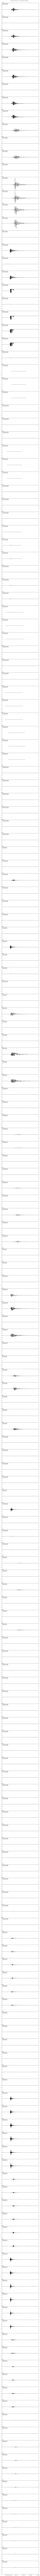

In [98]:
# reload the module to get the latest changes
import sys
sys.path.append('./my_funcs')
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import glob
import os 
# import all the `get_waveforms` function
from my_funcs.get_waveforms_parallel_v3 import *

# define the client list i.e. the data centers to download data from
client_list = ['NCEDC', 'IRIS'] #, 'SCEDC']

# get a list of all the event id folders
event_paths = glob.glob("../data/eq_data/*")
event_ids = [os.path.basename(path) for path in event_paths]

# Read earthquake data
eqdf = pd.read_csv("../data/above_slab_eq_df.csv", parse_dates=["time"])

# define the priority channels
priority_channels = ['HH*', 'BH*', 'HN*', 'EH*']

event_ids = ['nc73201181'] # test with one event
# loop through each event id and download the data
for event_id in event_ids:

    # define the output folder
    output_folder = f"../data/eq_data/{event_id}/"

    # check if the event data is already downloaded
    if os.path.exists(f"../data/eq_data/{event_id}/{event_id}.mseed"):
        print(f"Event {event_id} already downloaded. Skipping...")
        continue

    print(f"Getting data for event {event_id}")

    # Read the inventory
    inventory = read_inventory(f"../data/eq_data/{event_id}/inventory/station_inventory_{event_id}.xml")

    #get the event time, start time and end time
    eq = eqdf[eqdf.id == event_id] # get the event details
    event_time = UTCDateTime(pd.to_datetime(eq.time.values[0])) # get the event time in UTC format
    starttime = event_time - 30 # start time is 30 seconds before the event time
    endtime = event_time + 120 # end time is 120 seconds after the event time

    # Call the function with the desired parameters
    get_waveforms_parallel(client_list, inventory, starttime, endtime, output_folder, priority_channels)


# This code will result in a plot like this:
(This is only for one station and its 3 channels)
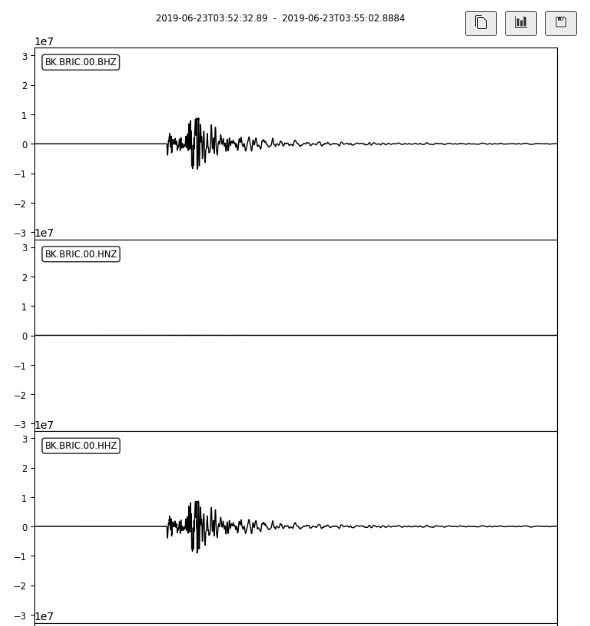